# Algotrading - 2021-1 - Entrega Intermediária

David Fogelman (davidf2@al.insper.edu.br)
___

Entrega intermediária do projeto da eletiva AlgoTrading. Esse notebook tem como objetivo mostrar a criação de uma estratégias baseado em três indicadores técnicos. 

Abaixo foram implementados os seguintes indicadores:
- MACD
- AROON
- ADRX
- Bollinger Bands (como definição de stop gain/loss) 

Os tickers escolhidos para realizar o backtest foram:

- AMZN
- BAC
- NOK

Os dados foram extraidos do yahoo finance que contem dados de high, low, open, close e volume com granularidade diária. Para a simulação foi considerado um histórico de 10 anos.
___

### MACD

O MACD (Moving Average Convergence Divergence) é um indicator de _momentum_ que gera o seu sinal a partir da diferença entre medias móveis de diferentes periodos. Sendo action um valor que pode oscilar entre 0 (venda) e 1 (compra).

$$ macd = EMA_{fast} - EMA_{slow}$$ 

$$ signal = EMA(macd) $$

$$ action = macd^{[t]} > signal^{[t]}$$


|parâmetro |valor|
--- | --- |
|período$_{fast}$|26|
|período$_{slow}$|12|
|período$_{signal}$|9|


### AROON

O Aroon retorna um valor de 0 a 100. O valor base para não entrarno mercado é 50. A partir desse base line definimos uma margem, no modelo a baixo foi utilizado 20.
            
$$ (Aroon_{up} > (50 + margin))   \&\& (Aroon_{down} < (50 - margin)) \Rightarrow 1 $$
$$ (Aroon_{down} > (50 + margin))   \&\& (Aroon_{up} < (50 - margin)) \Rightarrow -1 $$
$$ else \Rightarrow 0 $$

### ADX & ADXR

O indicador ADX retorna se o mercado está em uma tendência e o ADXR mostra a direção dessa tendência.

$$ signal = 0, se\ adx_{signal} < 25$$
$$ signal = 1, se\ adxr_{signal} > adx_{signal} $$
$$ signal = -1, se\ adxr_{signal} < adx_{signal}$$

### Bollinger Bands

Este indicador é apenas utilizado para marcar o stop loss e stop gain. Quando o preço é maior do que a upper band e estamos "vendidos", precisamos zerar a posição com preço a mercado. Se o preço atingir a lower band e estamos "comprados" da mesma maneira, zeramos a posição.

### Juntando os indicadores

Caso o indicator ADXR for zero, logo zeramos as posições já que indica que não estamos em tendência.

$$ signal = macd_{signal} + adxr_{signal} + aroon_{signal} $$

### Ajustando a posição para o sinal

Para não lançar ordens desnecessárias que zeraria a posição e recompraria novamente, no qual a carteira correria um risco maior, podemos calcular a diferença com a seguinte equação:

$$size = signal - position$$


In [1]:
%matplotlib inline

import talib
import datetime
import numpy as np
import pandas as pd
import yahoofinancials as yf
import matplotlib.pyplot as plt

from dateutil.relativedelta import relativedelta
from backtesting import evaluateHist, evaluateIntr, Strategy, Order

In [2]:
class CustomStrategy(Strategy):

    def __init__(self):
        
        # Quantidade de dias de cada média móvel
        self.slow = 26
        self.fast = 12
        self.signal = 9
        self.margin = 20
        self.timeperiod = 14
        
        # Lista para guardar os preços e o indicador
        self.prices = np.empty([0, 4])
        self.volume = []
        self.indicator = []
        self.indicator_macd = []
        self.indicator_adxr = []
        self.indicator_aroon = []
        self.indicator_bbands = []
    
        self.side = 0
        self.position = 0
        self.gain_id = 0

    @property
    def can_trade(self):
        return len(self.prices) >= self.slow + self.signal
    
    @property
    def _close(self):
        return self.prices[:,3]
    
    @property
    def _high(self):
        return self.prices[:,1]
    
    @property
    def _low(self):
        return self.prices[:,2]
    
    @property
    def MACD(self):
        close = self._close
        macd, macdsignal, macdhist = talib.MACD(close, fastperiod=self.fast, slowperiod=self.slow, signalperiod=self.signal)
        macd_signal = (macd[-1] > macdsignal[-1])*2 - 1    
        self.indicator_macd.append([macd[-1], macdsignal[-1]])
        return macd_signal

    @property
    def ADXR(self):
        signal = 0
        
        close = self._close
        high = self._high
        low = self._low
        timeperiod = self.timeperiod
        
        adxr = talib.ADXR(high, low, close, timeperiod=timeperiod)
        adx = talib.ADX(high, low, close, timeperiod=timeperiod)
        if adx[-1] < 30:
            signal = 0
        elif adx[-1] > adxr[-1]:
            signal = 1
        else:
            signal = -1
            
        self.indicator_adxr.append([adxr[-1], adx[-1]])
        return signal

    @property
    def BBANDS(self):
        signal = 0
        close = self._close
        upper, middle, lower = talib.BBANDS(close, matype=talib.MA_Type.T3)
        
        last_upper, last_middle, last_lower = upper[-1], middle[-1], lower[-1]
        self.indicator_bbands.append([last_upper, last_middle, last_lower])
        return last_upper, last_middle, last_lower
    
    @property
    def AROON(self):
        signal = 0
        
        high = self._high
        low = self._low
        
        aroondown, aroonup = talib.AROON(high, low, timeperiod=14)

        margin = self.margin
        marginup = 50 +margin
        margindown = 50 - margin
        if aroonup[-1] > marginup and aroondown[-1] < margindown:
            signal = 1
        elif aroondown[-1] > marginup and aroonup[-1] < margindown:
            signal = -1
        
        self.indicator_adxr.append([aroonup[-1], aroondown[-1]])
        return signal
    
    def push(self, event):
        orders = []
        self.prices = np.append(self.prices, np.array(event.price).reshape((1,-1)), axis=0)
        self.volume.append(event.quantity)
        if not self.can_trade:
            return orders

        # Stop Loss
        last_close = self._close[-1]
        high, _, low = self.BBANDS
        if (last_close < low and self.side > 0) or (last_close > high and self.side < 0):
            orders.append(Order(event.instrument, -self.side, 0))
            self.side = 0
        
        signal =  self.MACD + self.AROON + self.ADXR

        self.indicator.append([signal])  
        if self.side != signal:
            difference = signal - self.side
            orders.append(Order(event.instrument, difference, 0))
            self.side = signal
    
            if self.gain_id != 0:
                self.cancel(self.id, self.gain_id)
            
            gain = Order(event.instrument, -signal, high)
            self.gain_id = gain.id
            orders.append(gain)
            
        
        return orders

In [3]:
model = CustomStrategy()
print(evaluateHist(model, {'BAC': 'BAC.csv'}))

Number of trades: 4
Gross P&L: 1037.62
Gross Accumulated return: 5.77%
Gross Average Return: 0.88%
Net P&L: 1033.32
Hitting ratio: 75.00%
Max Profit: 1039.60
Max Drawdown: -2.11



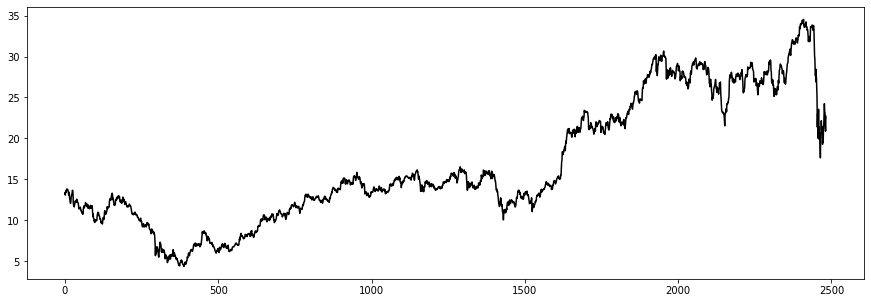

In [4]:
prices = model.prices
close = prices[:,3]
fig, ax = plt.subplots(1, 1, figsize=(15,5));
ax.plot(close[-len(model.indicator_macd):], color='black');

In [5]:
model = CustomStrategy()
print(evaluateHist(model, {'NOK': 'NOK.csv'}))

Number of trades: 3
Gross P&L: -299.79
Gross Accumulated return: -5.80%
Gross Average Return: -0.83%
Net P&L: -301.03
Hitting ratio: 33.33%
Max Profit: 0.21
Max Drawdown: -300.01



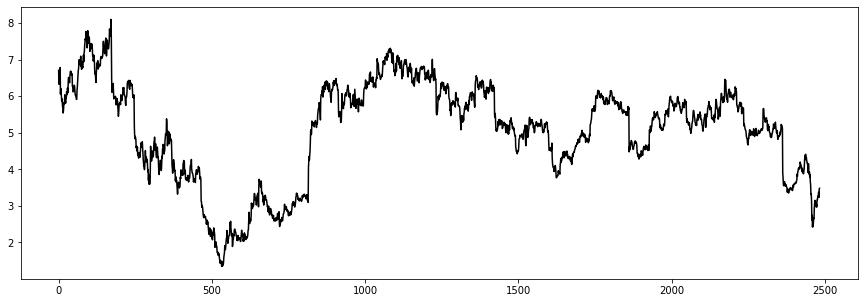

In [6]:
prices = model.prices
close = prices[:,3]
fig, ax = plt.subplots(1, 1, figsize=(15,5));
ax.plot(close[-len(model.indicator_macd):], color='black');

In [7]:
model = CustomStrategy()
print(evaluateHist(model, {'AMZN': 'AMZN.csv'}))

Number of trades: 2
Gross P&L: 244738.01
Gross Accumulated return: 28.64%
Gross Average Return: 14.32%
Net P&L: 244532.92
Hitting ratio: 100.00%
Max Profit: 244738.01
Max Drawdown: 0.00



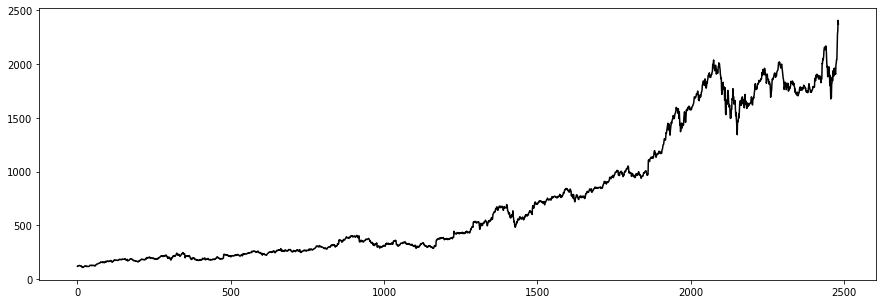

In [8]:
prices = model.prices
close = prices[:,3]
fig, ax = plt.subplots(1, 1, figsize=(15,5));
ax.plot(close[-len(model.indicator_macd):], color='black');

## Conclusão

Apesar do modelo apresentar ganhos na `AMZN` e `BAC` não se pode garantir que o modelo está preparado para ser implementado em produção já que mais testes precisam ser realizados. Quando a tendência de preço é de queda o modelo continua apostando para a tendência positiva, perdendo dinheiro como podemos ver na ação `NOK`.

## Referências
- https://mrjbq7.github.io/ta-lib/doc_index.html
- http://tadoc.org/indicator/HT_TRENDMODE.htm
- https://www.tradingpedia.com/videos/trend-vs-cycle-mode-understanding-hilbert-transform/
- https://www.investopedia.com/top-7-technical-analysis-tools-4773275
- https://www.investopedia.com/terms/a/aroonoscillator.asp
- https://www.daytrading.com/adx-adxr